# Predicción de Calidad del Vino con Redes Neuronales

En este notebook, exploraremos un problema más realista: predecir la calidad del vino basándonos en sus propiedades químicas. A diferencia de los ejemplos anteriores (conversión Celsius-Fahrenheit y XOR), este problema:

- Utiliza datos del mundo real con múltiples variables de entrada
- Presenta relaciones no lineales y complejas entre las variables
- Incluye evaluaciones subjetivas humanas (puntuaciones de calidad)
- No tiene una solución "perfecta" o exacta

Esto nos permitirá ver cómo funcionan las redes neuronales en situaciones más cercanas a aplicaciones reales.

## Importar bibliotecas necesarias

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix

# Configuración para evitar warnings
import warnings
warnings.filterwarnings("ignore")
import logging
tf.get_logger().setLevel(logging.ERROR)

## Cargar y explorar el conjunto de datos

Utilizaremos el conjunto de datos de Calidad del Vino de UCI Machine Learning Repository. Este dataset contiene varias propiedades químicas de vinos junto con puntuaciones de calidad (en una escala de 0-10) asignadas por expertos.

In [3]:
# Descargar el dataset directamente
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
try:
    wine_data = pd.read_csv(url, sep=';')
except:
    # Alternativa si la URL no funciona
    from sklearn.datasets import fetch_openml
    wine_data = fetch_openml(name="wine-quality-red", version=1, as_frame=True).frame

# Mostrar las primeras filas
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# Información básica del dataset
print(f"Forma del dataset: {wine_data.shape}")
print("\nInformación de las columnas:")
wine_data.info()

print("\nEstadísticas descriptivas:")
wine_data.describe()

Forma del dataset: (1599, 12)

Información de las columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

Estadísticas descriptivas:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### Exploración de la variable objetivo (calidad)

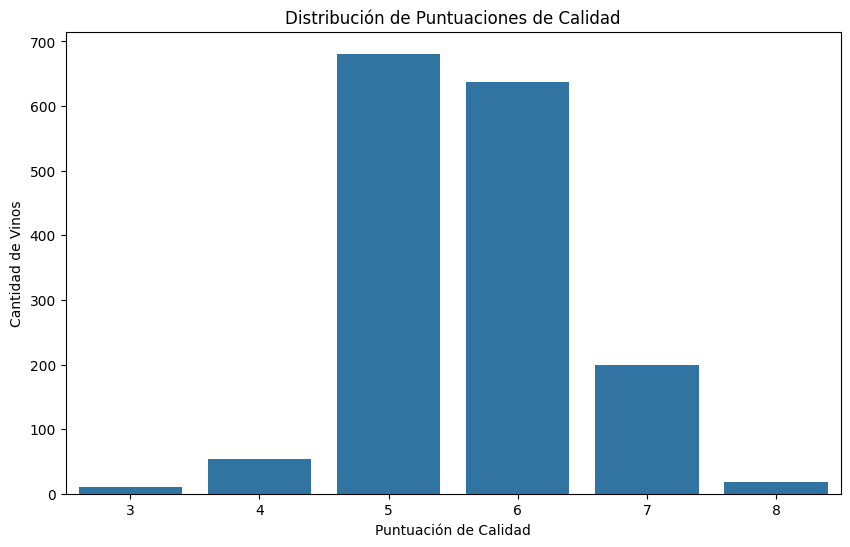

Puntuación mínima: 3
Puntuación máxima: 8
Puntuación media: 5.64
Desviación estándar: 0.81


In [5]:
# Distribución de las puntuaciones de calidad
plt.figure(figsize=(10, 6))
sns.countplot(x='quality', data=wine_data)
plt.title('Distribución de Puntuaciones de Calidad')
plt.xlabel('Puntuación de Calidad')
plt.ylabel('Cantidad de Vinos')
plt.show()

print(f"Puntuación mínima: {wine_data['quality'].min()}")
print(f"Puntuación máxima: {wine_data['quality'].max()}")
print(f"Puntuación media: {wine_data['quality'].mean():.2f}")
print(f"Desviación estándar: {wine_data['quality'].std():.2f}")

### Análisis de correlaciones

Veamos cómo se relacionan las diferentes propiedades químicas con la calidad del vino.

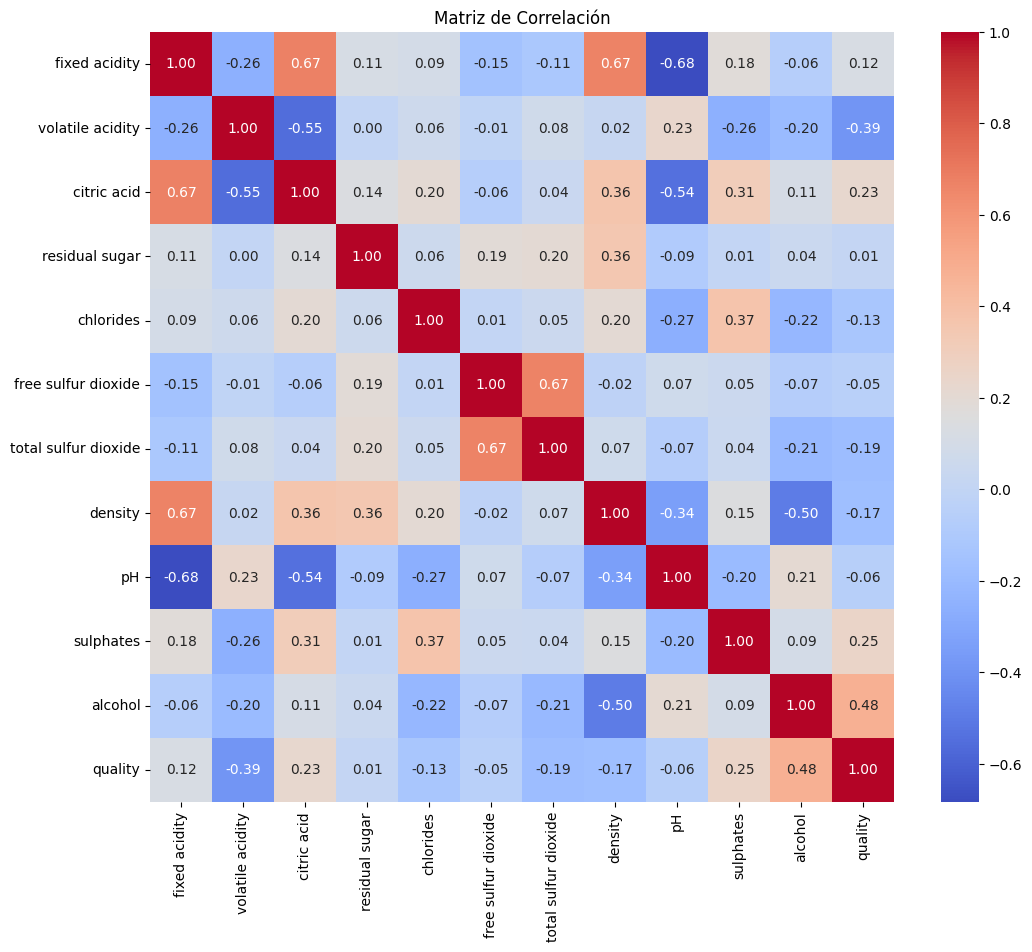

Correlaciones con la calidad del vino:
quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


In [6]:
# Matriz de correlación
plt.figure(figsize=(12, 10))
correlation_matrix = wine_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

# Correlaciones con la calidad
quality_correlations = correlation_matrix['quality'].sort_values(ascending=False)
print("Correlaciones con la calidad del vino:")
print(quality_correlations)

### Visualización de relaciones clave

Veamos las relaciones entre algunas de las características más correlacionadas con la calidad.

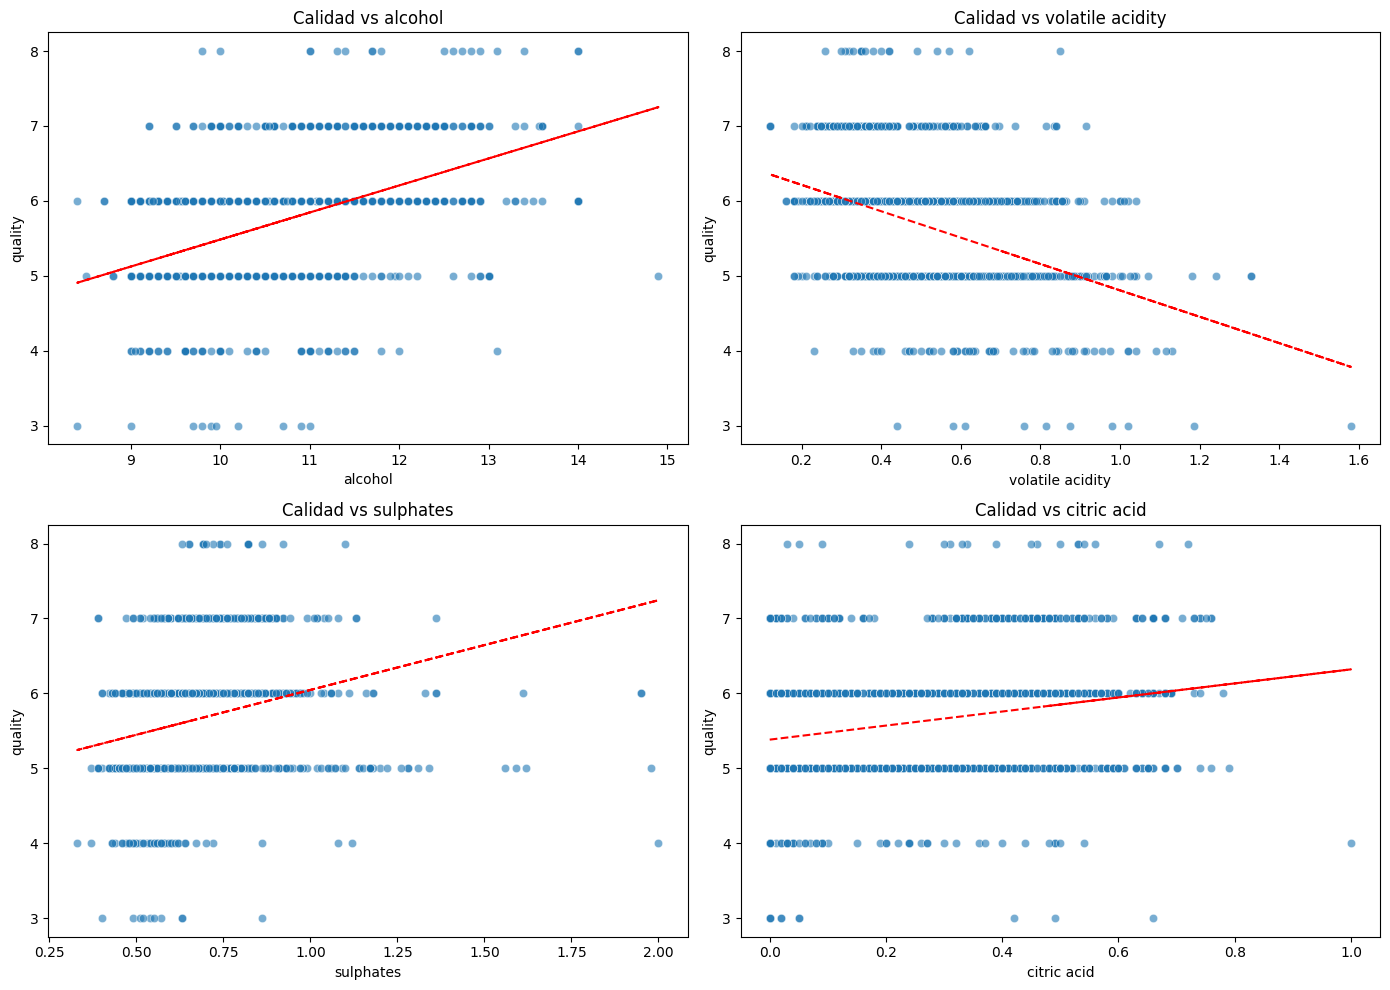

In [7]:
# Seleccionar las características con mayor correlación absoluta
top_features = quality_correlations.drop('quality').abs().sort_values(ascending=False).head(4).index.tolist()

# Crear gráficos de dispersión
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    sns.scatterplot(x=feature, y='quality', data=wine_data, ax=axes[i], alpha=0.6)
    axes[i].set_title(f'Calidad vs {feature}')
    
    # Añadir línea de tendencia
    x = wine_data[feature]
    y = wine_data['quality']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    axes[i].plot(x, p(x), "r--")
    
plt.tight_layout()
plt.show()

## Preparación de los datos para el entrenamiento

Ahora prepararemos los datos para entrenar nuestra red neuronal:
1. Separar características (X) y variable objetivo (y)
2. Dividir en conjuntos de entrenamiento y prueba
3. Normalizar las características para mejorar el entrenamiento

In [8]:
# Separar características y variable objetivo
X = wine_data.drop('quality', axis=1)
y = wine_data['quality']

# Dividir en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

# Normalizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a arrays de numpy si no lo son ya
X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)
y_train = np.array(y_train)
y_test = np.array(y_test)

Tamaño del conjunto de entrenamiento: 1279 muestras
Tamaño del conjunto de prueba: 320 muestras


## Construcción del modelo de red neuronal

Crearemos un perceptrón multicapa para predecir la calidad del vino. Trataremos esto como un problema de regresión, ya que queremos predecir una puntuación numérica.

In [9]:
# Definir la arquitectura del modelo
model = Sequential([
    # Capa de entrada: tamaño igual al número de características
    Dense(units=64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),  # Dropout para reducir el sobreajuste
    
    # Capa oculta
    Dense(units=32, activation='relu'),
    Dropout(0.2),
    
    # Capa de salida: una neurona para la predicción de calidad
    Dense(units=1)
])

# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',  # MSE es apropiado para regresión
    metrics=['mae']  # Error absoluto medio como métrica adicional
)

# Mostrar el resumen del modelo
model.summary()

2025-04-07 00:20:44.889790: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-07 00:20:45.072583: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-07 00:20:45.072739: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-07 00:20:45.078302: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-07 00:20:45.078538: I external/local_xla/xla/stream_executor

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo

Ahora entrenaremos nuestro modelo con los datos de entrenamiento. Utilizaremos early stopping para evitar el sobreajuste.

In [10]:
# Configurar early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorear la pérdida en el conjunto de validación
    patience=20,         # Número de épocas sin mejora antes de detenerse
    restore_best_weights=True  # Restaurar los mejores pesos encontrados
)

# Entrenar el modelo
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,  # 20% de los datos de entrenamiento se usan para validación
    callbacks=[early_stopping],
    verbose=1
)

print("Entrenamiento finalizado!")

Epoch 1/200


I0000 00:00:1743985266.121815   66229 service.cc:145] XLA service 0x7f514c003b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743985266.121871   66229 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-04-07 00:21:06.145615: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-07 00:21:06.276751: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.4164 - mae: 4.9010

I0000 00:00:1743985268.302440   66229 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 25.1319 - mae: 4.8668 - val_loss: 12.2739 - val_mae: 3.2282
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.1519 - mae: 2.7941 - val_loss: 4.7839 - val_mae: 1.7553
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2027 - mae: 1.8548 - val_loss: 3.1119 - val_mae: 1.3732
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7943 - mae: 1.5718 - val_loss: 2.5355 - val_mae: 1.2393
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4703 - mae: 1.4842 - val_loss: 2.2906 - val_mae: 1.1859
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2431 - mae: 1.4034 - val_loss: 2.0208 - val_mae: 1.1158
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9850 - mae: 1.3522 - val_loss: 1.8607 - val_mae: 1.0784
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7980 - mae: 1.3222 - val_loss: 1.6972 - val_mae: 1.0367
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8289 - mae:

## Visualización del proceso de entrenamiento

Veamos cómo evolucionó la pérdida y el error absoluto medio durante el entrenamiento.

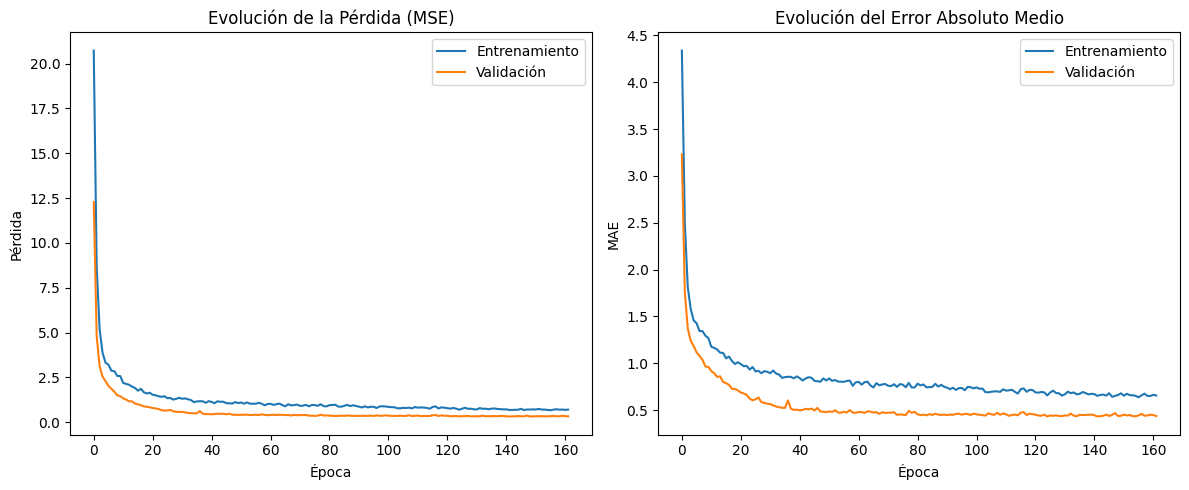

In [11]:
# Graficar la evolución de la pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de la Pérdida (MSE)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title('Evolución del Error Absoluto Medio')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluación del modelo

Ahora evaluaremos el rendimiento de nuestro modelo en el conjunto de prueba.

In [12]:
# Evaluar el modelo en el conjunto de prueba
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Pérdida (MSE) en el conjunto de prueba: {loss:.4f}")
print(f"Error absoluto medio en el conjunto de prueba: {mae:.4f}")

# Realizar predicciones
y_pred = model.predict(X_test_scaled).flatten()

# Calcular métricas adicionales
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse:.4f}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse:.4f}")
print(f"Coeficiente de determinación (R²): {r2:.4f}")

Pérdida (MSE) en el conjunto de prueba: 0.3681
Error absoluto medio en el conjunto de prueba: 0.4849
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Error cuadrático medio (MSE): 0.3681
Raíz del error cuadrático medio (RMSE): 0.6067
Coeficiente de determinación (R²): 0.4368


## Visualización de predicciones vs. valores reales

Comparemos las predicciones del modelo con los valores reales para ver qué tan bien funciona.

In [13]:
# Crear un DataFrame con valores reales y predicciones
results_df = pd.DataFrame({
    'Real': y_test,
    'Predicción': y_pred,
    'Error': y_test - y_pred
})

# Mostrar algunas filas
results_df.head(10)

,Real,Predicción,Error
0,6,5.388543,0.611457
1,5,5.144505,-0.144505
2,6,5.569396,0.430604
3,5,5.356681,-0.356681
4,6,5.687222,0.312778
5,5,5.233006,-0.233006
6,5,5.212965,-0.212965
7,5,4.867031,0.132969
8,5,5.757916,-0.757916
9,6,5.684874,0.315126


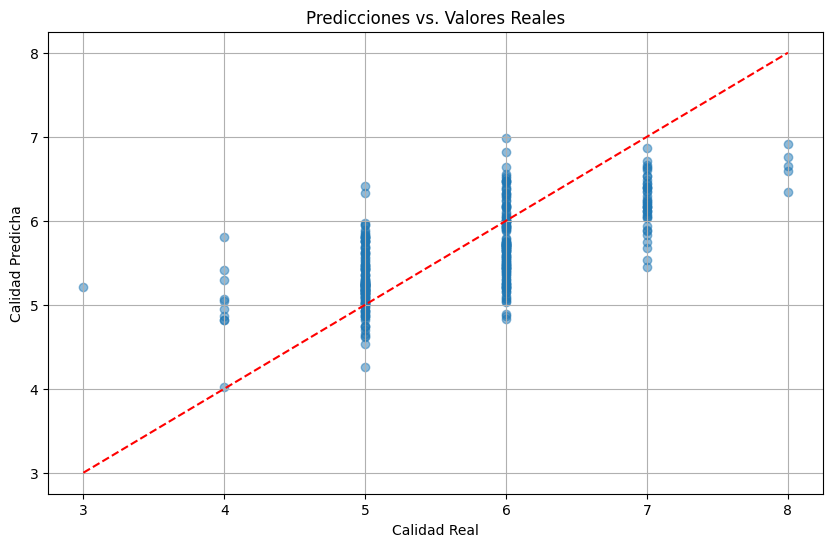

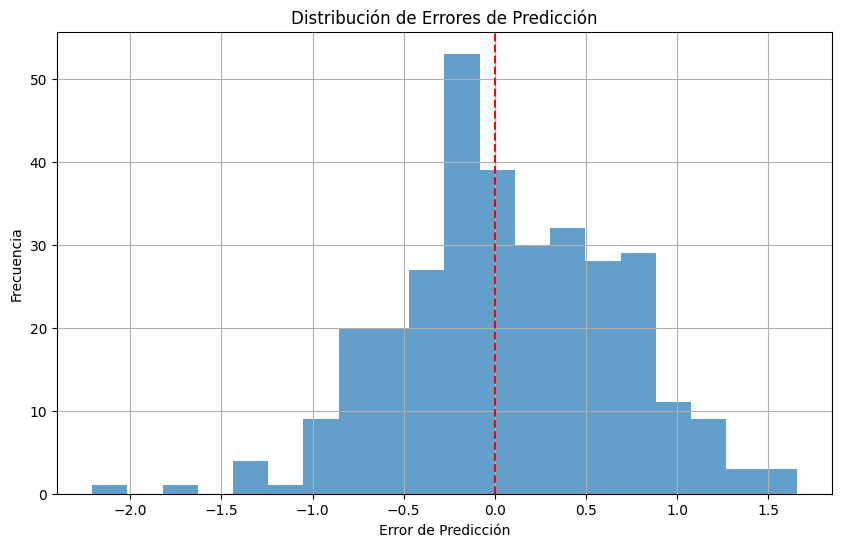

In [14]:
# Gráfico de dispersión: Valores reales vs. predicciones
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Calidad Real')
plt.ylabel('Calidad Predicha')
plt.title('Predicciones vs. Valores Reales')
plt.grid(True)
plt.show()

# Histograma de errores
plt.figure(figsize=(10, 6))
plt.hist(results_df['Error'], bins=20, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores de Predicción')
plt.grid(True)
plt.show()

## Análisis de predicciones por categoría

Veamos cómo se comporta el modelo para diferentes niveles de calidad.

Errores por nivel de calidad:
   Real      mean       std  count  abs_mean
0     3 -2.209678       NaN      1  2.209678
1     4 -1.009430  0.467022     10  1.009430
2     5 -0.291003  0.361954    130  0.363212
3     6  0.261771  0.438569    132  0.426977
4     7  0.775198  0.316224     42  0.775198
5     8  1.347311  0.212690      5  1.347311


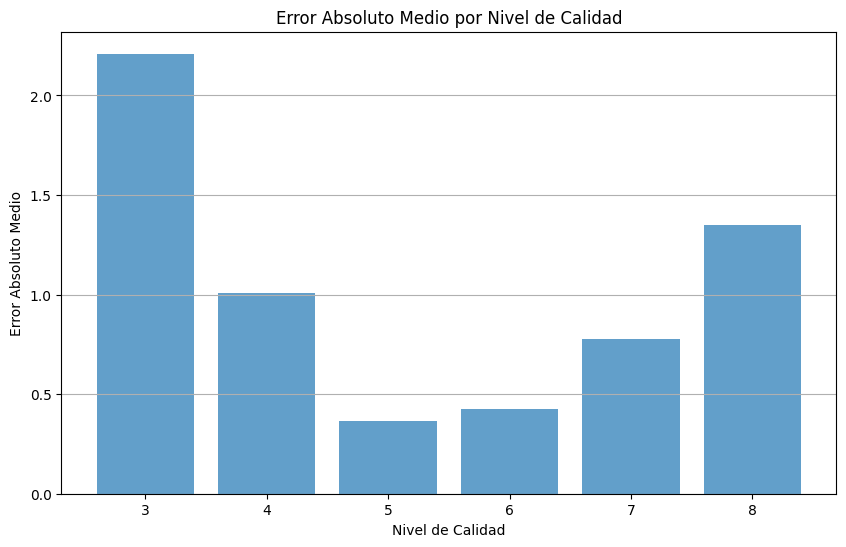

In [15]:
# Calcular el error medio absoluto por nivel de calidad
quality_errors = results_df.groupby('Real')['Error'].agg(['mean', 'std', 'count'])
quality_errors['abs_mean'] = results_df.groupby('Real')['Error'].apply(lambda x: np.abs(x).mean())
quality_errors = quality_errors.reset_index()

# Mostrar errores por nivel de calidad
print("Errores por nivel de calidad:")
print(quality_errors)

# Visualizar el error absoluto medio por nivel de calidad
plt.figure(figsize=(10, 6))
plt.bar(quality_errors['Real'], quality_errors['abs_mean'], alpha=0.7)
plt.xlabel('Nivel de Calidad')
plt.ylabel('Error Absoluto Medio')
plt.title('Error Absoluto Medio por Nivel de Calidad')
plt.grid(True, axis='y')
plt.show()

## Enfoque alternativo: Clasificación en lugar de regresión

Podemos tratar este problema como una tarea de clasificación, redondeando las predicciones al entero más cercano y evaluando la precisión.

Precisión (predicciones exactas): 0.5844 (58.44%)
Precisión con tolerancia de ±1: 0.9875 (98.75%)


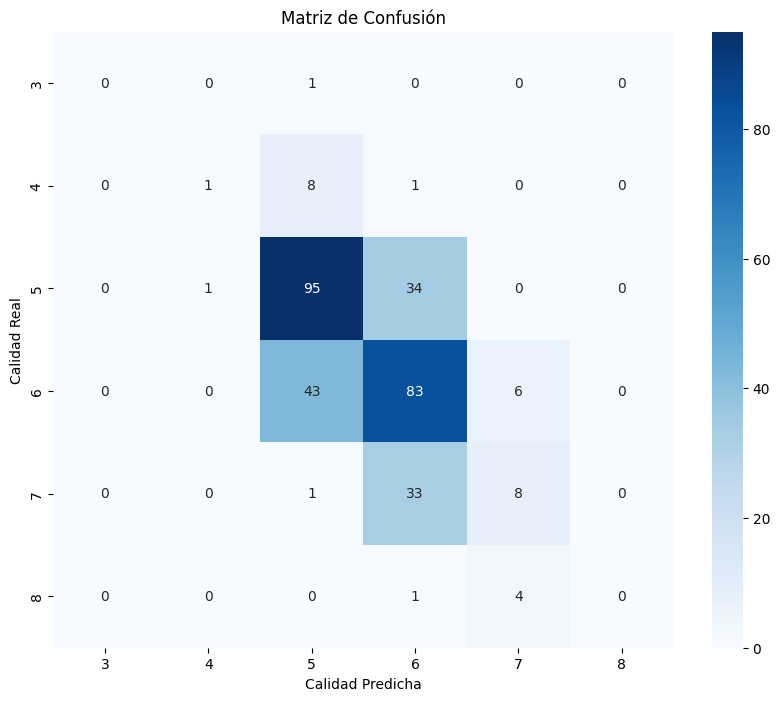

In [16]:
# Redondear las predicciones al entero más cercano
y_pred_rounded = np.round(y_pred).astype(int)

# Calcular la precisión (porcentaje de predicciones exactas)
accuracy = np.mean(y_pred_rounded == y_test)
print(f"Precisión (predicciones exactas): {accuracy:.4f} ({accuracy*100:.2f}%)")

# Calcular la precisión con tolerancia de ±1
accuracy_tolerance = np.mean(np.abs(y_pred_rounded - y_test) <= 1)
print(f"Precisión con tolerancia de ±1: {accuracy_tolerance:.4f} ({accuracy_tolerance*100:.2f}%)")

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_rounded)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(np.unique(y_test)),
            yticklabels=sorted(np.unique(y_test)))
plt.xlabel('Calidad Predicha')
plt.ylabel('Calidad Real')
plt.title('Matriz de Confusión')
plt.show()

In [17]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Calculate classification metrics
precision = precision_score(y_test, y_pred_rounded, average='weighted')
recall = recall_score(y_test, y_pred_rounded, average='weighted')
f1 = f1_score(y_test, y_pred_rounded, average='weighted')

print("Métricas de Clasificación:")
print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Detailed classification report
print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred_rounded))

# Calculate per-class accuracy
class_accuracy = pd.DataFrame({
    'Calidad': np.unique(y_test),
    'Precisión por Clase': [np.mean(y_pred_rounded[y_test == c] == c) for c in np.unique(y_test)]
})

print("\nPrecisión por Nivel de Calidad:")
print(class_accuracy)

Métricas de Clasificación:
Precisión: 0.5600
Recall: 0.5844
F1-Score: 0.5590

Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.50      0.10      0.17        10
           5       0.64      0.73      0.68       130
           6       0.55      0.63      0.58       132
           7       0.44      0.19      0.27        42
           8       0.00      0.00      0.00         5

    accuracy                           0.58       320
   macro avg       0.36      0.28      0.28       320
weighted avg       0.56      0.58      0.56       320


Precisión por Nivel de Calidad:
   Calidad  Precisión por Clase
0        3             0.000000
1        4             0.100000
2        5             0.730769
3        6             0.628788
4        7             0.190476
5        8             0.000000


## Predicción con nuevos datos

Veamos cómo podríamos usar el modelo para predecir la calidad de nuevos vinos.

In [18]:
# Crear algunos ejemplos de vinos ficticios
new_wines = pd.DataFrame({
    'fixed acidity': [7.5, 8.2, 6.8],
    'volatile acidity': [0.3, 0.7, 0.2],
    'citric acid': [0.4, 0.1, 0.5],
    'residual sugar': [2.0, 1.8, 2.5],
    'chlorides': [0.08, 0.09, 0.05],
    'free sulfur dioxide': [30, 15, 40],
    'total sulfur dioxide': [100, 80, 120],
    'density': [0.996, 0.998, 0.994],
    'pH': [3.2, 3.4, 3.1],
    'sulphates': [0.7, 0.5, 0.9],
    'alcohol': [10.5, 9.0, 12.0]
})

# Normalizar los nuevos datos usando el mismo scaler
new_wines_scaled = scaler.transform(new_wines)

# Realizar predicciones
new_predictions = model.predict(new_wines_scaled).flatten()
new_predictions_rounded = np.round(new_predictions).astype(int)

# Mostrar resultados
print("Predicciones para nuevos vinos:")
for i, (pred, pred_round) in enumerate(zip(new_predictions, new_predictions_rounded)):
    print(f"Vino {i+1}: Predicción = {pred:.2f}, Redondeado = {pred_round}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
Predicciones para nuevos vinos:
Vino 1: Predicción = 5.69, Redondeado = 6
Vino 2: Predicción = 4.96, Redondeado = 5
Vino 3: Predicción = 6.19, Redondeado = 6


## Análisis de importancia de características

Aunque las redes neuronales no proporcionan directamente la importancia de las características como otros modelos (por ejemplo, árboles de decisión), podemos hacer un análisis simple basado en permutaciones para estimar qué características son más importantes para nuestro modelo.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ -2s -208723us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

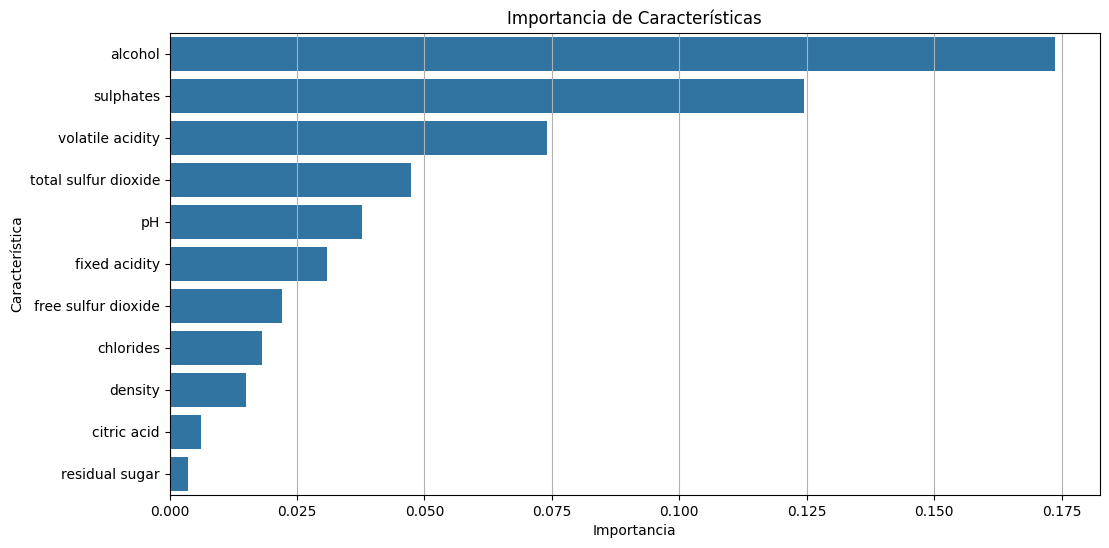

In [19]:
# Función para calcular la importancia de características mediante permutación
def permutation_importance(model, X, y, n_repeats=10):
    baseline_mse = mean_squared_error(y, model.predict(X))
    importances = []
    
    for i in range(X.shape[1]):
        feature_importances = []
        
        for _ in range(n_repeats):
            # Crear una copia de X
            X_permuted = X.copy()
            # Permutar la característica i
            np.random.shuffle(X_permuted[:, i])
            # Calcular el MSE con la característica permutada
            permuted_mse = mean_squared_error(y, model.predict(X_permuted))
            # La importancia es el aumento en el error
            importance = permuted_mse - baseline_mse
            feature_importances.append(importance)
        
        importances.append(np.mean(feature_importances))
    
    return np.array(importances)

# Calcular la importancia de las características
feature_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats=5)

# Crear un DataFrame con las importancias
importance_df = pd.DataFrame({
    'Característica': X.columns,
    'Importancia': feature_importance
}).sort_values('Importancia', ascending=False)

# Mostrar las importancias
print("Importancia de características (basada en permutación):")
print(importance_df)

# Visualizar las importancias
plt.figure(figsize=(12, 6))
sns.barplot(x='Importancia', y='Característica', data=importance_df)
plt.title('Importancia de Características')
plt.grid(True, axis='x')
plt.show()

## Conclusiones

En este notebook, hemos explorado cómo utilizar una red neuronal para predecir la calidad del vino basándonos en sus propiedades químicas. A diferencia de los ejemplos anteriores (conversión Celsius-Fahrenheit y XOR), este problema presenta varias características del mundo real:

1. **Múltiples variables de entrada**: Utilizamos 11 características químicas diferentes, lo que hace que el problema sea más complejo.

2. **Relaciones no lineales**: Las relaciones entre las propiedades químicas y la calidad no son simples ni lineales.

3. **Subjetividad en los datos**: Las puntuaciones de calidad son evaluaciones humanas subjetivas, lo que introduce cierta "imperfección" en los datos.

4. **Solución no exacta**: A diferencia de la conversión Celsius-Fahrenheit, no existe una fórmula exacta para calcular la calidad del vino.

### Observaciones clave:

- El modelo logra un error cuadrático medio (RMSE) de aproximadamente 0.6-0.7 puntos en la escala de calidad, lo que es razonable considerando la naturaleza subjetiva de las evaluaciones.

- La precisión exacta (cuando redondeamos las predicciones) es moderada, pero mejora significativamente si consideramos predicciones con un margen de error de ±1 punto.

- Algunas propiedades químicas tienen mayor influencia en la calidad que otras, como el contenido de alcohol y la acidez volátil.

- El modelo muestra mayor dificultad para predecir correctamente los vinos de calidad muy alta o muy baja, probablemente debido a la menor cantidad de ejemplos en estas categorías.

### Comparación con los ejemplos anteriores:

A diferencia de la conversión Celsius-Fahrenheit (relación lineal perfecta) o el problema XOR (problema lógico con solución exacta), este ejemplo muestra cómo las redes neuronales pueden aplicarse a problemas del mundo real donde:

1. No existe una fórmula exacta que relacione las entradas con las salidas
2. Los datos contienen cierto grado de subjetividad y ruido
3. Las relaciones entre variables son complejas y no lineales
4. El rendimiento perfecto no es alcanzable debido a la naturaleza del problema

Este tipo de problemas son mucho más representativos de las aplicaciones reales del aprendizaje automático, donde el objetivo no es obtener una precisión perfecta, sino extraer patrones útiles de datos complejos e imperfectos.